In [2]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")

<h2>Import data</h2>
We manually set up headers and types for better accuracy and control over them.<br/>
parse_dates is used to convert the date into a datetime object type<br/>
sep=';' specifies that the values are separated by a ';' symbol in the .csv file<br/>
skiprows=1 skips the 1st row of the .csv file as that's the headers<br/>

In [3]:
#import data
headers = ['time_utc', 'external_mapping_id', 'active_power_watt','possible_power_watt','wind_speed','rpm','active_stop','control_state_id','online_data_expired','wind_direction','temperature','active_stop_user_id','received_time_utc']

parse_dates = ['time_utc', 'received_time_utc']
df = pd.read_csv("../AssetsData/new_online_data.csv", sep=',', names=headers, parse_dates=parse_dates, skiprows=1)
df.head()

print(df.dtypes)


C:\Users\chmel\AppData\Local\Temp\ipykernel_17924\817497124.py:5: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../online_data/new_online_data.csv", sep=',', names=headers, parse_dates=parse_dates, skiprows=1)


time_utc               datetime64[ns]
external_mapping_id             int64
active_power_watt             float64
possible_power_watt           float64
wind_speed                    float64
rpm                           float64
active_stop                    object
control_state_id              float64
online_data_expired            object
wind_direction                float64
temperature                   float64
active_stop_user_id           float64
received_time_utc      datetime64[ns]
dtype: object


In [4]:
#drop useless column based on NETRA's suggestions
df.drop(columns=['possible_power_watt', 'active_stop_user_id'], inplace=True, axis=1)
print(f"Amount of N/A values in the data frame: {df.isna().sum().sum()}")

Amount of N/A values in the data frame: 393808


<h2>Handle missing values</h2>

In [5]:
#drop rows with missing values
df.dropna(subset=['wind_speed', 'temperature', 'wind_direction'], inplace=True, axis=0)

#replacing missing values of recevied_time_utc to values of time_utc as they a
df.received_time_utc.fillna(df.time_utc, inplace=True)

#replace negative values with 0 to ...
# Get names of indexes for which column rpm is below 0
indexNames = df[df['rpm'] < 0 ].index

# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)
print(f"Amount of N/A values in the data frame: {df.isna().sum().sum()}")


Amount of N/A values in the data frame: 0


<h2>Data formatting</h2>

In [6]:
df.columns = ['time_utc', 'id', 'active_power_watt','wind_speed_ms','rpm','active_stopped','control_state_id','online_data_expired','wind_direction_degrees','temperature','received_time_utc']

df.replace(['FALSE', 'TRUE'], [0, 1], inplace=True)
#df['active_power_watt'] = df['active_power_watt'].replace('\.','', regex=True).astype(float).astype('int32')

dtypes = {
    'id':np.uint8,
    'active_power_watt':np.int64,
    'wind_speed_ms':np.float32,
    'rpm':np.int32,
    'active_stopped':np.uint8,
    'control_state_id':np.uint8,
    'online_data_expired':np.uint8,
    'wind_direction_degrees':np.float32,
    'temperature':np.float32
}
df = df.astype(dtypes)
df.info()

indexNames = df[df['active_power_watt'] < 0 ].index
df.drop(indexNames , inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708120 entries, 0 to 724468
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   time_utc                708120 non-null  datetime64[ns]
 1   id                      708120 non-null  uint8         
 2   active_power_watt       708120 non-null  int64         
 3   wind_speed_ms           708120 non-null  float32       
 4   rpm                     708120 non-null  int32         
 5   active_stopped          708120 non-null  uint8         
 6   control_state_id        708120 non-null  uint8         
 7   online_data_expired     708120 non-null  uint8         
 8   wind_direction_degrees  708120 non-null  float32       
 9   temperature             708120 non-null  float32       
 10  received_time_utc       708120 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float32(3), int32(1), int64(1), uint8(4)
memory usage: 35.1 MB
<class

<h2>Data preprocessing</h2>

In [7]:
#split control_state_id in 5 different columns with 0 & 1 values
df = pd.get_dummies(df, columns=['control_state_id'], prefix='control_state', drop_first = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538271 entries, 1 to 724468
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   time_utc                538271 non-null  datetime64[ns]
 1   id                      538271 non-null  uint8         
 2   active_power_watt       538271 non-null  int64         
 3   wind_speed_ms           538271 non-null  float32       
 4   rpm                     538271 non-null  int32         
 5   active_stopped          538271 non-null  uint8         
 6   online_data_expired     538271 non-null  uint8         
 7   wind_direction_degrees  538271 non-null  float32       
 8   temperature             538271 non-null  float32       
 9   received_time_utc       538271 non-null  datetime64[ns]
 10  control_state_2         538271 non-null  uint8         
 11  control_state_5         538271 non-null  uint8         
 12  control_state_6         538271

In [8]:
# moving columns
df = df[['time_utc','id','wind_speed_ms','temperature', 'wind_direction_degrees', 'rpm','active_stopped', 'online_data_expired', 'received_time_utc','control_state_2','control_state_5','control_state_6','control_state_7','active_power_watt']]
# and rename the control state ids to more meaningful values
df.rename(columns={'control_state_2':'control_state_running','control_state_5':'control_state_stopping','control_state_6':'control_state_foreign_stop','control_state_7':'control_state_starting'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538271 entries, 1 to 724468
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   time_utc                    538271 non-null  datetime64[ns]
 1   id                          538271 non-null  uint8         
 2   wind_speed_ms               538271 non-null  float32       
 3   temperature                 538271 non-null  float32       
 4   wind_direction_degrees      538271 non-null  float32       
 5   rpm                         538271 non-null  int32         
 6   active_stopped              538271 non-null  uint8         
 7   online_data_expired         538271 non-null  uint8         
 8   received_time_utc           538271 non-null  datetime64[ns]
 9   control_state_running       538271 non-null  uint8         
 10  control_state_stopping      538271 non-null  uint8         
 11  control_state_foreign_stop  538271 non-

We plot histograms of the values that we want to normalize to decide on a mathematical normalization function

In [27]:
# histograms after normalization
y_axis_max = 500000
def subplot_hists():
    figure, axis = plt.subplots(2, 2, constrained_layout = True)

    # For Sine Function
    #sns.histplot(data=df['temperature'].astype(np.int32), kde=True, ax=axis[0, 0], binwidth=1)
    axis[0, 0].hist(df['temperature'])
    axis[0, 0].set_title("temperature")
    axis[0, 0].set_ylim([0, y_axis_max])

    # For Cosine Function
    axis[0, 1].hist(df['wind_direction_degrees'])
    axis[0, 1].set_title("wind_direction_degrees")
    axis[0, 1].set_ylim([0, y_axis_max])

    # For Tangent Function
    axis[1, 0].hist(df['rpm'])
    axis[1, 0].set_title("rpm")
    axis[1, 0].set_ylim([0, y_axis_max])

    # For Tanh Function
    axis[1, 1].hist(df['wind_speed_ms'])
    axis[1, 1].set_title("wind_speed_ms")
    axis[1, 1].set_ylim([0, y_axis_max])

    # Combine all the operations and display
    plt.show()

subplot_hists()

In [28]:
# Based on the above histogram the folliwng normalizations were applied
# normalize the values

# linear clipping (min/max) for flat value destribution
df['rpm'] = (df['rpm']-df['rpm'].min())/(df['rpm'].max()-df['rpm'].min())   

# normalize with sin values of the degrees for circular values
df['wind_direction_degrees'] = np.sin(np.deg2rad(df['wind_direction_degrees']))
    
# z-score for already bell-like spread values
for column in ['temperature','wind_speed_ms']:
    df[column]=(df[column]-df[column].mean())/df[column].std()

df.head()

time_utc  id  wind_speed_ms  temperature  \
1  2022-03-27 00:00:00.034  49      -1.439479     0.030971   
6  2022-03-27 00:00:30.305  49      -1.364664     0.030971   
8  2022-03-27 00:00:29.281  93      -1.065408     1.163162   
10 2022-03-27 00:00:29.282  96      -0.840965     1.163162   
11 2022-03-27 00:00:29.281  97      -0.766151     1.163162   

    wind_direction_degrees       rpm  active_stopped  online_data_expired  \
1            -8.660254e-01  0.305198               0                    0   
6            -7.880107e-01  0.301286               0                    0   
8            -2.923718e-01  0.585802               0                    0   
10           -8.742278e-08  0.558971               0                    0   
11           -8.715581e-02  0.558971               0                    0   

         received_time_utc  control_state_running  control_state_stopping  \
1  2022-03-27 00:00:00.034                      1                       0   
6  2022-03-27 00:00:30.305                      1                       0   
8  2022-03-27 00:00:29.281                      1                       0   
10 2022-03-27 00:00:29.282                      1                       0   
11 2022-03-27 00:00:29.281                      1                       0   

    control_state_foreign_stop  control_state_starting  active_power_watt  
1                            0                       0               1700  
6                            0                       0               2700  
8                            0                       0              42800  
10                           0                       0              40500  
11                           0                       0              50200

In [29]:
subplot_hists()

<h1>Exploratory Data Analysis</h1>
<h2>Descriptive statistics</h2>
Let's check what is the description of the dataframe right now


In [30]:
df.describe().apply(lambda s: s.apply('{0:.10f}'.format))

id      wind_speed_ms        temperature  \
count  538271.0000000000  538271.0000000000  538271.0000000000   
mean       68.5899463282       0.0000000127      -0.0000000132   
std        22.2787441204       1.0000000000       0.9999999404   
min        47.0000000000      -2.4120635986      -2.9882040024   
25%        49.0000000000      -0.7661508322      -0.7238228321   
50%        54.0000000000      -0.2050442249       0.0309709348   
75%        94.0000000000       0.5805051327       0.4083678126   
max        97.0000000000       5.2938008308       3.8049397469   

      wind_direction_degrees                rpm     active_stopped  \
count      538271.0000000000  538271.0000000000  538271.0000000000   
mean           -0.0490096621       0.6378227119       0.0003566976   
std             0.7535938621       0.1647862007       0.0188830897   
min            -1.0000000000       0.0000000000       0.0000000000   
25%            -0.8571671844       0.5449972051       0.0000000000   
50%            -0.0174523946       0.6025712689       0.0000000000   
75%             0.7071067691       0.7769703745       0.0000000000   
max             1.0000000000       1.0000000000       1.0000000000   

      online_data_expired control_state_running control_state_stopping  \
count   538271.0000000000     538271.0000000000      538271.0000000000   
mean         0.0038865181          0.9994203663           0.0000798854   
std          0.0622207385          0.0240686265           0.0089375152   
min          0.0000000000          0.0000000000           0.0000000000   
25%          0.0000000000          1.0000000000           0.0000000000   
50%          0.0000000000          1.0000000000           0.0000000000   
75%          0.0000000000          1.0000000000           0.0000000000   
max          1.0000000000          1.0000000000           1.0000000000   

      control_state_foreign_stop control_state_starting   active_power_watt  
count          538271.0000000000      538271.0000000000   538271.0000000000  
mean                0.0000037156           0.0002749544  1026814.8924983883  
std                 0.0019275875           0.0165794858  1019457.0907300515  
min                 0.0000000000           0.0000000000        0.0000000000  
25%                 0.0000000000           0.0000000000   208800.0000000000  
50%                 0.0000000000           0.0000000000   673600.0000000000  
75%                 0.0000000000           0.0000000000  1554200.0000000000  
max                 1.0000000000           1.0000000000  3742300.0000000000

The wind direction, wind speed and temperature have a mean of around 0 and a standard deviation of 1. The rpm is normalized using the min-max method.


In [31]:
answer = input('Run all the regplot? (y/n)') == 'y'


if answer:
    newId = int(input('Choose an asset id: '))
    sns.regplot(x = "wind_speed_ms", y = "active_power_watt", data = df[df.id == newId], scatter_kws={"color": "blue"}, line_kws={"color": "red"}).set(title='Linear Relationship between active power & wind speed')
    plt.xlabel("Wind Speed")
    plt.ylabel("Active Power")
    plt.show()

we can see a clear linear relationship between windspeed and active power

In [32]:
if answer:
    sns.regplot(x="temperature", y = "active_power_watt", data = df[df.id == newId], scatter_kws={"color": "blue"}, line_kws={"color": "red"}).set(title="LR between active power & temperature")
    plt.xlabel("Temperature")
    plt.ylabel("Active Power")
    plt.show()

In [33]:
if answer:
    sns.regplot(x="wind_direction_degrees", y = "active_power_watt", data = df[df.id == newId], scatter_kws={"color": "blue"}, line_kws={"color": "red"}).set(title='LR between wind direction & active power')
    plt.xlabel("Wind Direction")
    plt.ylabel("Active Power")
    plt.show()

In [34]:
if answer:
    sns.regplot(x="rpm", y = "active_power_watt", data = df[df.id == newId], scatter_kws={"color": "blue"}, line_kws={"color": "red"}).set(title='LR between RPM & active power')
    plt.xlabel("RPM")
    plt.ylabel("Active Power")
    plt.show()

In [35]:
from scipy import stats
import matplotlib.pyplot as plt
pearson_coef, p_value = stats.pearsonr(df['wind_speed_ms'], df['active_power_watt'])
print('Wind Speed')
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

pearson_coef, p_value = stats.pearsonr(df['wind_direction_degrees'], df['active_power_watt'])
print('Wind Direction')
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

pearson_coef, p_value = stats.pearsonr(df['rpm'], df['active_power_watt'])
print('RPM')
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

pearson_coef, p_value = stats.pearsonr(df['temperature'], df['active_power_watt'])
print('Temperature')
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)



Wind Speed
The Pearson Correlation Coefficient is 0.9191950743997923  with a P-value of P = 0.0
Wind Direction
The Pearson Correlation Coefficient is 0.03043515027471418  with a P-value of P = 1.709655073631415e-110
RPM
The Pearson Correlation Coefficient is 0.7359977121761222  with a P-value of P = 0.0
Temperature
The Pearson Correlation Coefficient is 0.008066309027234224  with a P-value of P = 3.2570611176351423e-09


[Text(0.5, 1.0, 'Correlations for all assets')]

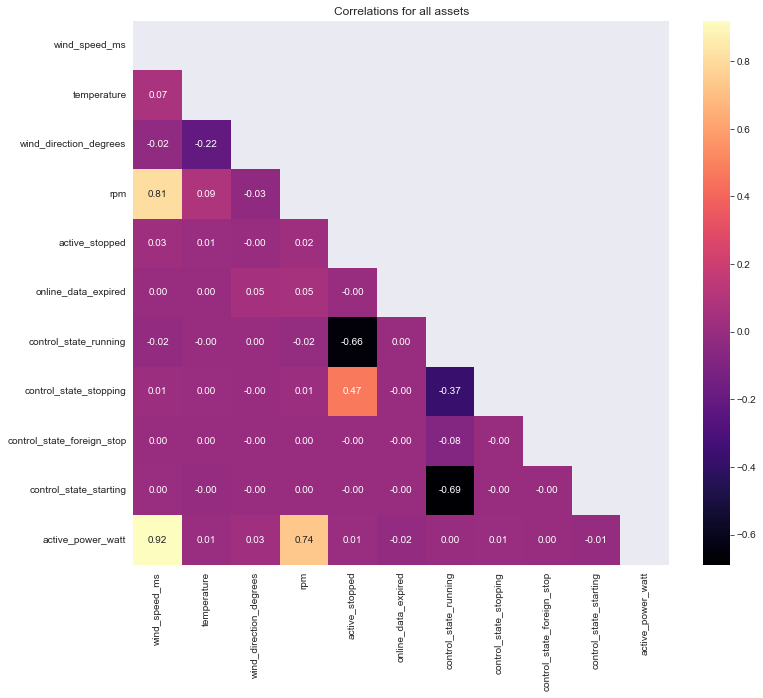

In [36]:
plt.figure(figsize=(12,10))
corr = df.drop(columns=['id'], axis=1).corr()
p = sns.heatmap(corr,annot=True,cmap="magma",fmt='.2f',mask=np.triu(np.ones_like(corr, dtype=bool)))
p.set(title = "Correlations for all assets")

In [37]:
coefs = []
for assetId in df['id'].unique():
    pearson_coef, p_value = stats.pearsonr(df[df.id == assetId]['wind_direction_degrees'], df[df.id == assetId]['active_power_watt'])
    coefs.append(pearson_coef)

coefs = np.abs(coefs)
print(np.average(coefs))


pearson_coef, p_value = stats.pearsonr(df['wind_direction_degrees'], df['active_power_watt'])
print(pearson_coef)


0.13043605359462496
0.03043515027471418


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'wind_speed_ms'),
  Text(0, 1.5, 'temperature'),
  Text(0, 2.5, 'wind_direction_degrees'),
  Text(0, 3.5, 'rpm'),
  Text(0, 4.5, 'active_power_watt')])

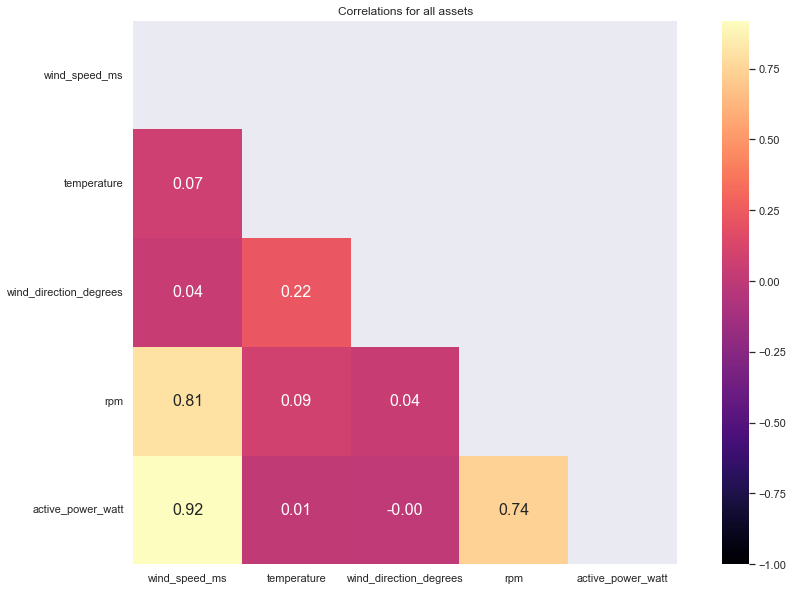

In [57]:
plt.figure(figsize=(16,10))
corr = df.drop(columns=['id', 'online_data_expired', 'active_stopped', 'control_state_running', 'control_state_stopping', 'control_state_foreign_stop', 'control_state_starting'], axis=1).corr()
p = sns.heatmap(corr,annot=True,square=True, vmin=-1,cmap="magma",fmt='.2f', annot_kws={"fontsize":16},mask=np.triu(np.ones_like(corr, dtype=bool)))
sns.set(font_scale=1)
p.set(title = "Correlations for all assets")
plt.yticks(rotation=0)

In [39]:
df = df[['time_utc', 'id', 'wind_speed_ms', 'wind_direction_degrees', 'temperature', 'active_power_watt']]
df.to_csv("../online_data/formatted_data_march.csv", index = False)